In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from typing import Optional, Union, List, Callable, Tuple
import pennylane as qml 
import networkx as nx
from tqdm import tqdm
import jax 
import jax.numpy as jnp
import random
import optax 
from scipy.linalg import eigh
from optimization import CSnGradient

Snob2 initialized.



In [ ]:
# optax.piecewise_interpolate_schedule

### For the 12-site Square model with frustration

In [2]:
lattice =[[(1,2), (1,8), (2,3), (2,7), (3,4), (3,6), (4,5), (5,6), (5, 12),
            (6,7), (6, 11), (7, 10), (7, 8), (8,9), (9, 10), (10, 11), (11, 12)],

           [(1,3), (1,9), (1,7), (2,4), (2,8), (2, 10), (2, 6), (3, 11), (3,5), (3,7),
            (4, 12), (4, 6), (5, 7), (5, 11), (6, 8), (6, 10), (6, 12),  (7, 9), (7, 11), (8, 10),
            (9, 11), (10, 12)]]

# Kagome Lattice: 

# lattice = [[(1,2), (1,5), (2,3), (3,4), (3,6),
#              (5,7), (7, 9), (7,8), (6,10), (9,10), (10,11), (10,12)],
#             [(2,5), (4,6), (6,9), (8,9), (11,12), (1,3),
#             (2,4), (3,10), (2,6), (6,11), (6,12), (9,11),
#             (9, 12), (5, 8), (1,7), (7, 10), (5,9)]]
partit = [int(6),int(6)]
Nsites = int(12)


In [5]:
# J2=0.5
lr = 0.01
p =4

CsnFourier = CSnGradient(J= [1.0, 0.0], 
                        lattice = lattice, 
                        Nsites=Nsites,
                        partit=partit ,p=p, num_samples =int(1000), max_iter =5000, lr=lr)

Ham_rep = CsnFourier.Ham_rep()


E_gs, V_gs = eigh(Ham_rep.astype('float64'), subset_by_index=[0,1])
V_gs = V_gs[:,0]
E_gs = E_gs[0]
V_gs = jnp.asarray(V_gs)
print('True Ground state Energy via ED for partition {}:--- ({}) '.format(partit, E_gs))
# print('True Ground State wavefuncion in Sn irrep basis for partition {}:--- {}'.format(partit, V_gs))

print('Irrep Dims for {}: --- {}'.format(partit, CsnFourier.dim))

print('now the gradient phase')



learning_rate_fn = optax.cosine_decay_schedule(
    init_value=lr,
    decay_steps=2500, 
    alpha=0.1)
optimizer = optax.adamw(learning_rate=learning_rate_fn)

# scheduled_adam = optax.inject_hyperparams(optax.scale_by_adam)(b1=optax.piecewise_interpolate_schedule(interpolate_type='linear', init_value=0.95), 
                                                                # b2=optax.piecewise_interpolate_schedule(interpolate_type='linear', init_value=0.95))
loss_history_jax, param_history_jax =CsnFourier.train(optimizer)
loss_history_jax = jnp.array(loss_history_jax) 
# print(loss_history)

True Ground state Energy via ED for partition [6, 6]:--- (-6.691680185898362) 
Irrep Dims for [6, 6]: --- 132
now the gradient phase


100%|██████████| 5000/5000 [06:16<00:00, 13.27it/s] 


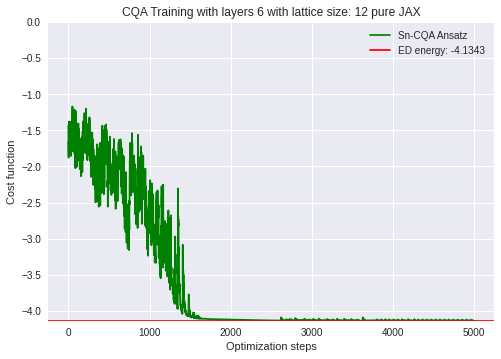

loss hostory with pure JAX and 2-nd YJM: -4.134135723114014


In [28]:
plt.style.use("seaborn")
plt.plot(loss_history_jax , "g", label='Sn-CQA Ansatz')
plt.axhline(E_gs, color='r', linestyle='-', label='ED energy: {:.4f}'.format(E_gs))
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.legend(loc="upper right")
plt.ylim([E_gs, 0])
plt.title(f'CQA Training with layers {p} with lattice size: {Nsites} pure JAX') 
plt.show()
# plt.savefig(f'Figures/CQA_p{myargs.p}_lattice{myargs.num_qubits}')  
print(f'loss hostory with pure JAX and 2-nd YJM: {min(loss_history_jax)}')

In [27]:
min(loss_history_jax - E_gs)

DeviceArray(0.00015736, dtype=float32)

In [29]:
# jnp.save('cqa_losses/12_kagome_J05.npy', loss_history_jax)

### For the noise model

In [3]:
lr = 0.01
p=4

noise_loss = []
sigmas = [0.005, 0.01, 0.05]
for sigma in sigmas:
    CsnFourier = CSnGradient(J= [1.0, 0.0], 
                            lattice = lattice, 
                            Nsites=Nsites,
                            partit=partit ,p=p, num_samples =int(1000), max_iter=5000, lr=lr, sigma=sigma, quantumnoise=True)
    learning_rate_fn = optax.cosine_decay_schedule(
        init_value=lr,
        decay_steps=2500, 
        alpha=0.1)
    # optimizer = optax.adamw(learning_rate=learning_rate_fn)

    scheduled_adam = optax.inject_hyperparams(optax.adamw)(learning_rate = learning_rate_fn)
    # CsnFourier.quantumnoise = True
    loss_history_jax_noise, param_history_jax_noise =CsnFourier.train(scheduled_adam)
    loss_history_jax_noise = jnp.array(loss_history_jax_noise) 
    noise_loss.append(loss_history_jax_noise)

100%|██████████| 5000/5000 [06:26<00:00, 12.93it/s] 


True Ground state Energy via ED for partition [6, 6]:--- (-6.691680185898362) 
Irrep Dims for [6, 6]: --- 132


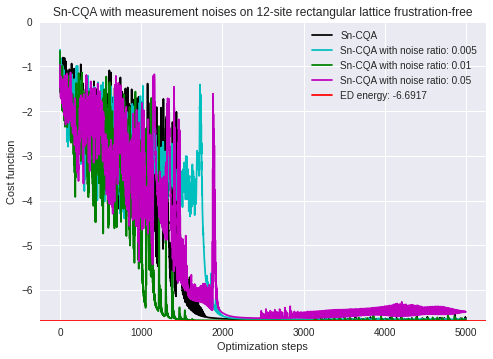

loss hostory with pure JAX and 2-nd YJM: -6.634145736694336


In [7]:
Ham_rep = CsnFourier.Ham_rep()


E_gs, V_gs = eigh(Ham_rep.astype('float64'), subset_by_index=[0,1])
V_gs = V_gs[:,0]
E_gs = E_gs[0]
V_gs = jnp.asarray(V_gs)
print('True Ground state Energy via ED for partition {}:--- ({}) '.format(partit, E_gs))
# print('True Ground State wavefuncion in Sn irrep basis for partition {}:--- {}'.format(partit, V_gs))

print('Irrep Dims for {}: --- {}'.format(partit, CsnFourier.dim))

# print(len(loss_history_jax_noise))
# perfect_loss = np.load('cqa_losses/12_rec_J05.npy')
plt.style.use("seaborn")
plt.plot(loss_history_jax , "k", label=f'Sn-CQA')
plt.plot(noise_loss[0] , "c", label=f'Sn-CQA with noise ratio: {sigmas[0]}')
plt.plot(noise_loss[1] , "g", label=f'Sn-CQA with noise ratio: {sigmas[1]}')
plt.plot(noise_loss[2] , "m", label=f'Sn-CQA with noise ratio: {sigmas[2]}')
plt.axhline(E_gs, color='r', linestyle='-', label='ED energy: {:.4f}'.format(E_gs))
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.legend(loc="upper right")
plt.ylim([E_gs, 0])
plt.title(f'Sn-CQA with measurement noises on {Nsites}-site rectangular lattice frustration-free') 
plt.show()
# plt.savefig(f'Figures/CQA_p{myargs.p}_lattice{myargs.num_qubits}')  
print(f'loss hostory with pure JAX and 2-nd YJM: {min(loss_history_jax_noise)}')

In [35]:
# import pandas as pd 
# df = pd.read_csv('../../data/NetKet_J08_kagome.csv')
# energy_RBM = df['RBM'].values
# energy_gcnn = df['GCNN'].values
# E_gs = df['Exact'].values
# print(energy_gcnn.shape)
# print(min(energy_gcnn))
# CQA_energy = np.load('cqa_losses/12_kagome_J08.npy')

(5000,)
-4.958007034919457


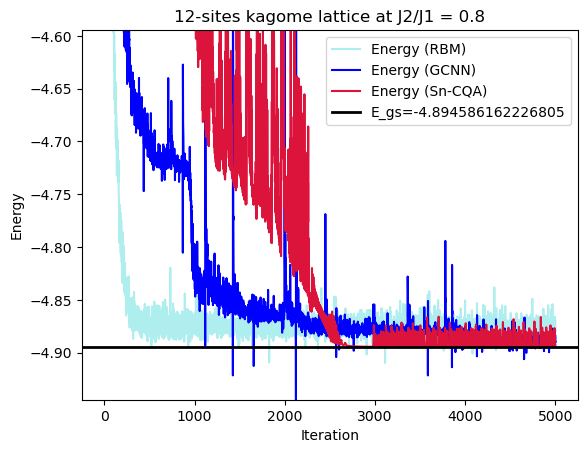

In [37]:
# plt.style.use("default")
# fig, ax1 = plt.subplots()
# ax1.plot(energy_RBM, color='paleturquoise', label='Energy (RBM)')
# ax1.plot(energy_gcnn, color='blue', label='Energy (GCNN)')
# ax1.plot(CQA_energy, color='crimson', label='Energy (Sn-CQA)')

# ax1.set_ylabel('Energy')
# ax1.set_xlabel('Iteration')
# ax1.set_ylim([E_gs[0] - 0.05, E_gs[0] + 0.3])
# # plt.axis([0,iters_RBM[-1],exact_gs_energy-0.03,exact_gs_energy+0.2])
# plt.axhline(y=E_gs[0], xmin=0,
#                 xmax=len(energy_gcnn), linewidth=2, color='k', label=f'E_gs={E_gs[0]}')
# ax1.legend()
# plt.title('12-sites kagome lattice at J2/J1 = 0.8')
# plt.show()
# # fig.savefig('../data/Kagome_J08.png')

In [42]:
# energy_recJ05 = np.load('cqa_losses/12_rec_J05.npy')
# energy_recJ08 = np.load('cqa_losses/12_rec_J08.npy')
# energy_kagJ05 = np.load('cqa_losses/12_kagome_J05.npy')
# energy_kagJ08 = np.load('cqa_losses/12_kagome_J08.npy')

# df1 = pd.read_csv('../../data/Netket_J05_6square.csv')
# df2 = pd.read_csv('../../data/Netket_J08_6square.csv')
# df3 = pd.read_csv('../../data/Netket_J05_Kagome.csv')
# df4 = pd.read_csv('../../data/NetKet_J08_kagome.csv')
# Egs_recJ05 = df1['Exact'].values[0]
# Egs_recJ08 = df2['Exact'].values[0]
# Egs_kagJ05 = df3['Exact'].values[0]
# Egs_kagJ08 = df4['Exact'].values[0]

(5000,)
-4.155302150557489


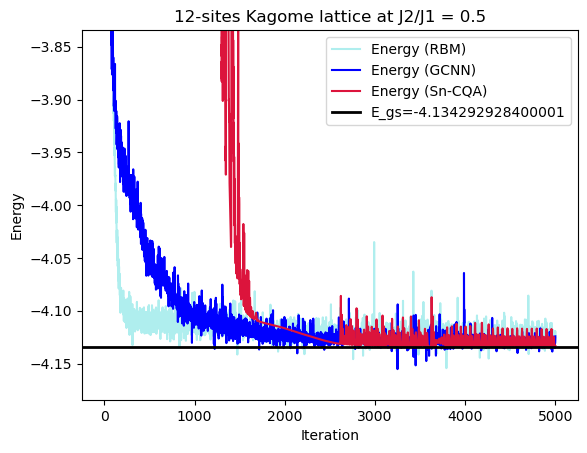

In [7]:
import pandas as pd 
df = pd.read_csv('../../data/Netket_J05_Kagome.csv')
energy_RBM = df['RBM'].values
energy_gcnn = df['GCNN'].values
E_gs = df['Exact'].values
print(energy_gcnn.shape)
print(min(energy_gcnn))
CQA_energy = np.load('cqa_losses/12_kagome_J05.npy')

plt.style.use("default")
fig, ax1 = plt.subplots()
ax1.plot(energy_RBM, color='paleturquoise', label='Energy (RBM)')
ax1.plot(energy_gcnn, color='blue', label='Energy (GCNN)')
ax1.plot(CQA_energy, color='crimson', label='Energy (Sn-CQA)')

ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
ax1.set_ylim([E_gs[0] - 0.05, E_gs[0] + 0.3])
# plt.axis([0,iters_RBM[-1],exact_gs_energy-0.03,exact_gs_energy+0.2])
plt.axhline(y=E_gs[0], xmin=0,
                xmax=len(energy_gcnn), linewidth=2, color='k', label=f'E_gs={E_gs[0]}')
ax1.legend()
plt.title('12-sites Kagome lattice at J2/J1 = 0.5')
plt.show()
# fig.savefig('../data/Kagome_J08.png')